In [ ]:
!apt-get install -y xvfb x11-utils# install required python dependencies
!apt-get install x11-utils
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.*
    
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install seaborn

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import autograd.numpy as np
from autograd import grad, elementwise_grad
import random
from IPython import display
import math
import seaborn as sns
import csv
import sys

```
This submission has both Q learning and Value Iteration Algorithm for the cartpole balance problem in gym.
The plots are included for both the algorithms and this problem was good enough to learn the Q learning and Value Iteration algorithm.
```

In [ ]:
class CartPoleQAgent():
    def __init__(self, buckets=(3, 3, 6, 6), 
                 num_episodes=500, min_lr=0.1, 
                 min_epsilon=0.1, discount=1.0, decay=25):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        self.env = gym.make('CartPole-v0')
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.steps = np.zeros(self.num_episodes)
        
    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i])) 
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])
        
    def get_action(self, state, e):
        obs = self.discretize_state(state)
        action_vector = self.Q_table[obs]
        epsilon = self.get_epsilon(e)
        action_vector = self.normalize(action_vector, epsilon)
        return action_vector

    def normalize(self, action_vector, epsilon):
        total = sum(action_vector)
        new_vector = (1-epsilon)*action_vector/(total)
        new_vector += epsilon/2.0
        return new_vector

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += (self.learning_rate * 
                                        (reward 
                                         + self.discount * np.max(self.Q_table[new_state]) 
                                         - self.Q_table[state][action]))

    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_learning_rate(self, t):
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def train(self):
        for e in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())
            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)
            done = False
            while not done:
                self.steps[e] += 1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                
        print('Finished training!')
    
    def plot_learning(self):
        sns.lineplot(range(len(self.steps)),self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")
    
    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                screen =self.env.render(mode="rgb_array")
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
                plt.imshow(screen)
                ipythondisplay.clear_output(wait=True)
                ipythondisplay.display(plt.gcf())

        ipythondisplay.clear_output(wait=True)
        env.close()
            
        return t

In [ ]:
def load_q_learning():
    agent = CartPoleQAgent()
    agent.train()
    agent.plot_learning()

    return agent

Finished training!


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


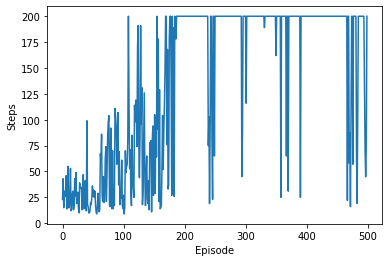

292 episodes were successfully completed.


In [ ]:
agent = load_q_learning()

```
Plots the number of steps at each episode and prints the
amount of times that an episode was successfully completed.
```

Episodes before solving:  96


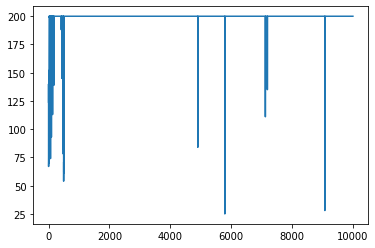

In [17]:
def approx(weights, state, action):
    return np.dot(state, weights)[action]

def policy(env, weights, state, epsilon):
    actions = [0, 1]
    if np.random.rand() < epsilon:
        return random.choice(actions)
    qs = []
    for action in actions:
        qs.append(approx(weights, state, action))
    return np.argmax(qs)

gradientApprox = grad(approx)
episodes = 10000
discount = 0.95
epsilon = 0.1
alpha = 0.1

env = gym.make('CartPole-v0')
epRewards = []
w = np.zeros((4,2))
for e in range(episodes):
    state = env.reset()
    rewards = []
    while True:
        action = policy(env, w, state, epsilon)
        q_hat = approx(w, state, action)
        q_hat_grad = gradientApprox(w, state, action)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            w += alpha*(reward - q_hat) * q_hat_grad
            break
        else:
            next_action = policy(env, w, next_state, epsilon)
            q_hat_next = approx(w, next_state, next_action)
            w += alpha*(reward - discount*q_hat_next)*q_hat_grad
            state = next_state
    epRewards.append(np.sum(rewards))
    
for i, _ in enumerate(epRewards):
    if i + 100 >= len(epRewards):
        break
    else:
        mean = np.mean(epRewards[i:i+100])
        if mean >= 195:
            print("Episodes before solving: ", i+1)
            break

plt.plot(epRewards)

In [18]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

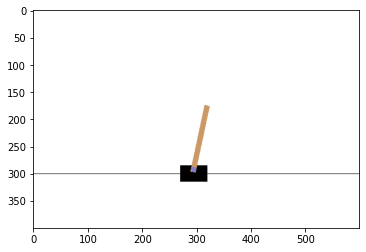

In [19]:


env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()


In [20]:
display.stop()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] oserror=None return_code=0 stdout="" stderr="" timeout_happened=False>